## Workbook 1 - Extracting and Exploring UrbanSound8K Audio Data 

The feature extraction process is based on example code posted by Aaqib Saeed
http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/

First, here's the imports. The audio processing is handled by a library called librosa, if you haven't already installed it on your local system, do that with: pip install librosa

In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

We'll begin by doing some basic visualisation of the audio data.

In [15]:
def load_sound_files(parent_dir, file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(parent_dir + fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,20), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.95,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,20), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.95,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,20), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.95,fontsize=18)
    plt.show()

In [3]:
sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                   "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]

parent_dir = 'samples/us8k/'

raw_sounds = load_sound_files(parent_dir, sound_file_paths)

Each sound can be visualised by how it changes over time. The classic view is the waveform, which shows the amplitude (relative loudness) of the sound at each successive time interval, this is what you'll see if you load an audio file into a sound editor like Audacity. 

Matplotlib provides an alternative visualisation method called specgram - which calculates and plots the different intensities of the freqency spectrum. 

Another visualisation provided by Librosa is the log power spectrogram plotting. 

By looking at the plots shown in Figure 1, 2 and 3, we can see apparent differences between sound clips of different classes. These differences are what we want our deep learning system to learn and interpret.

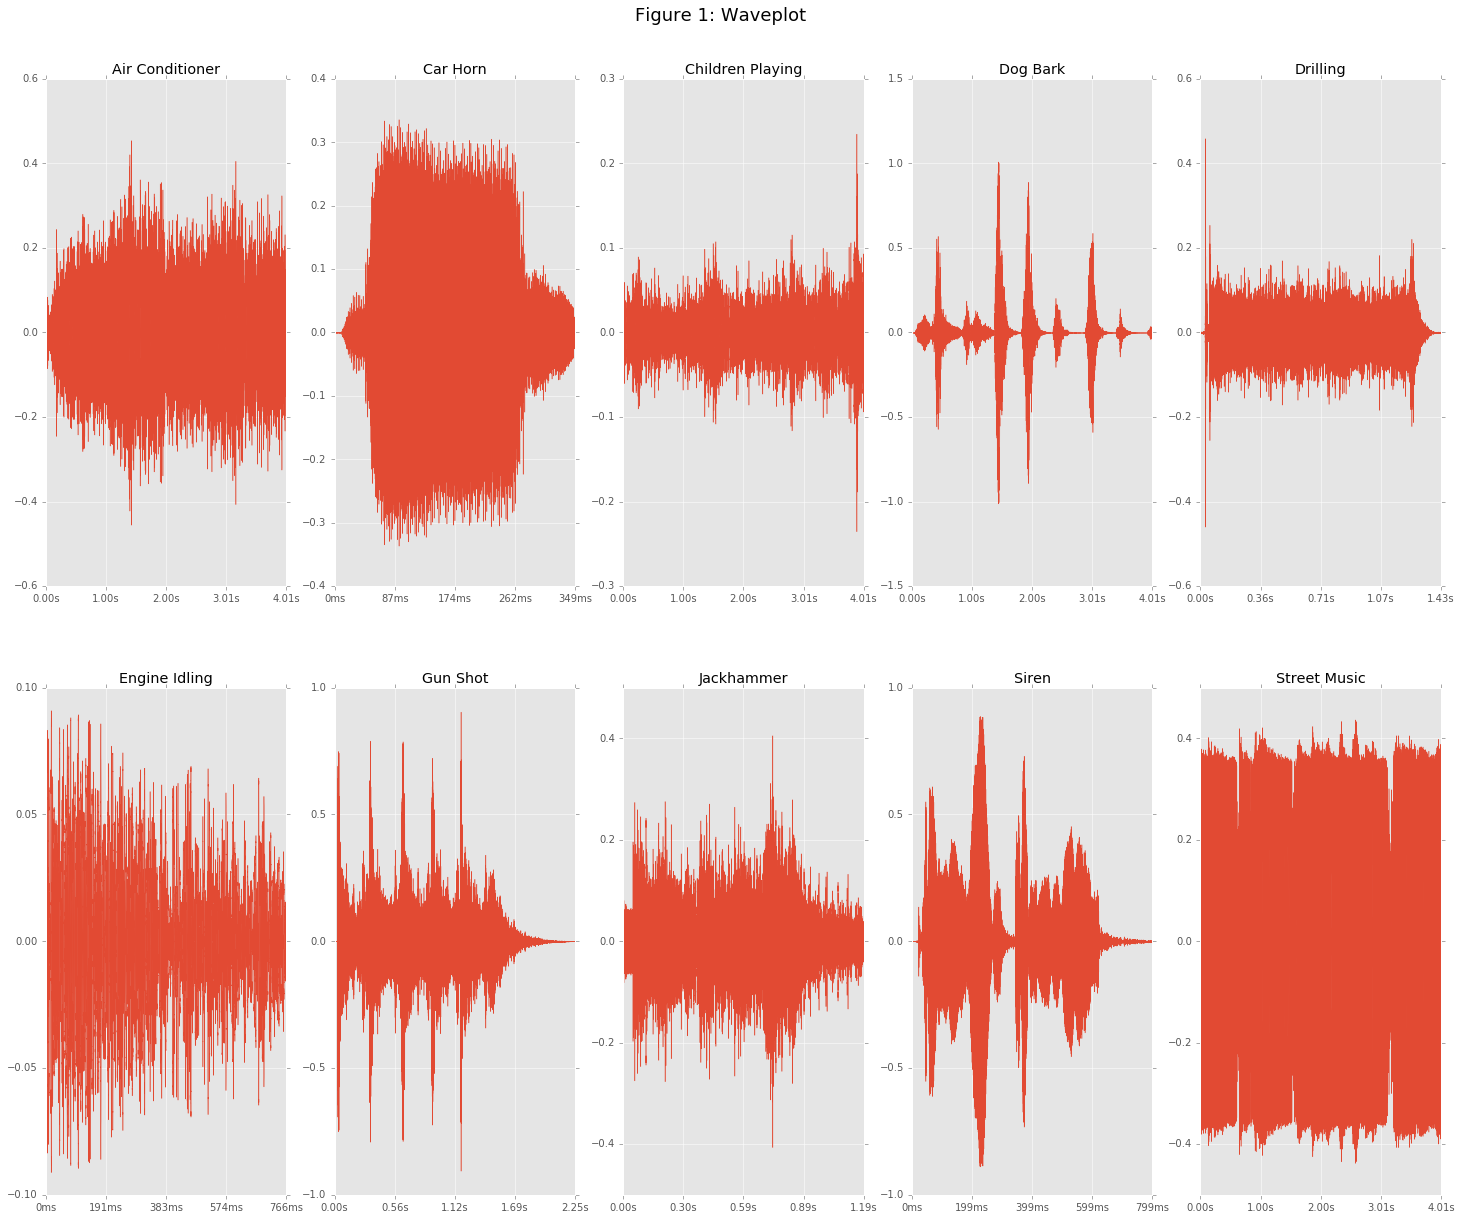

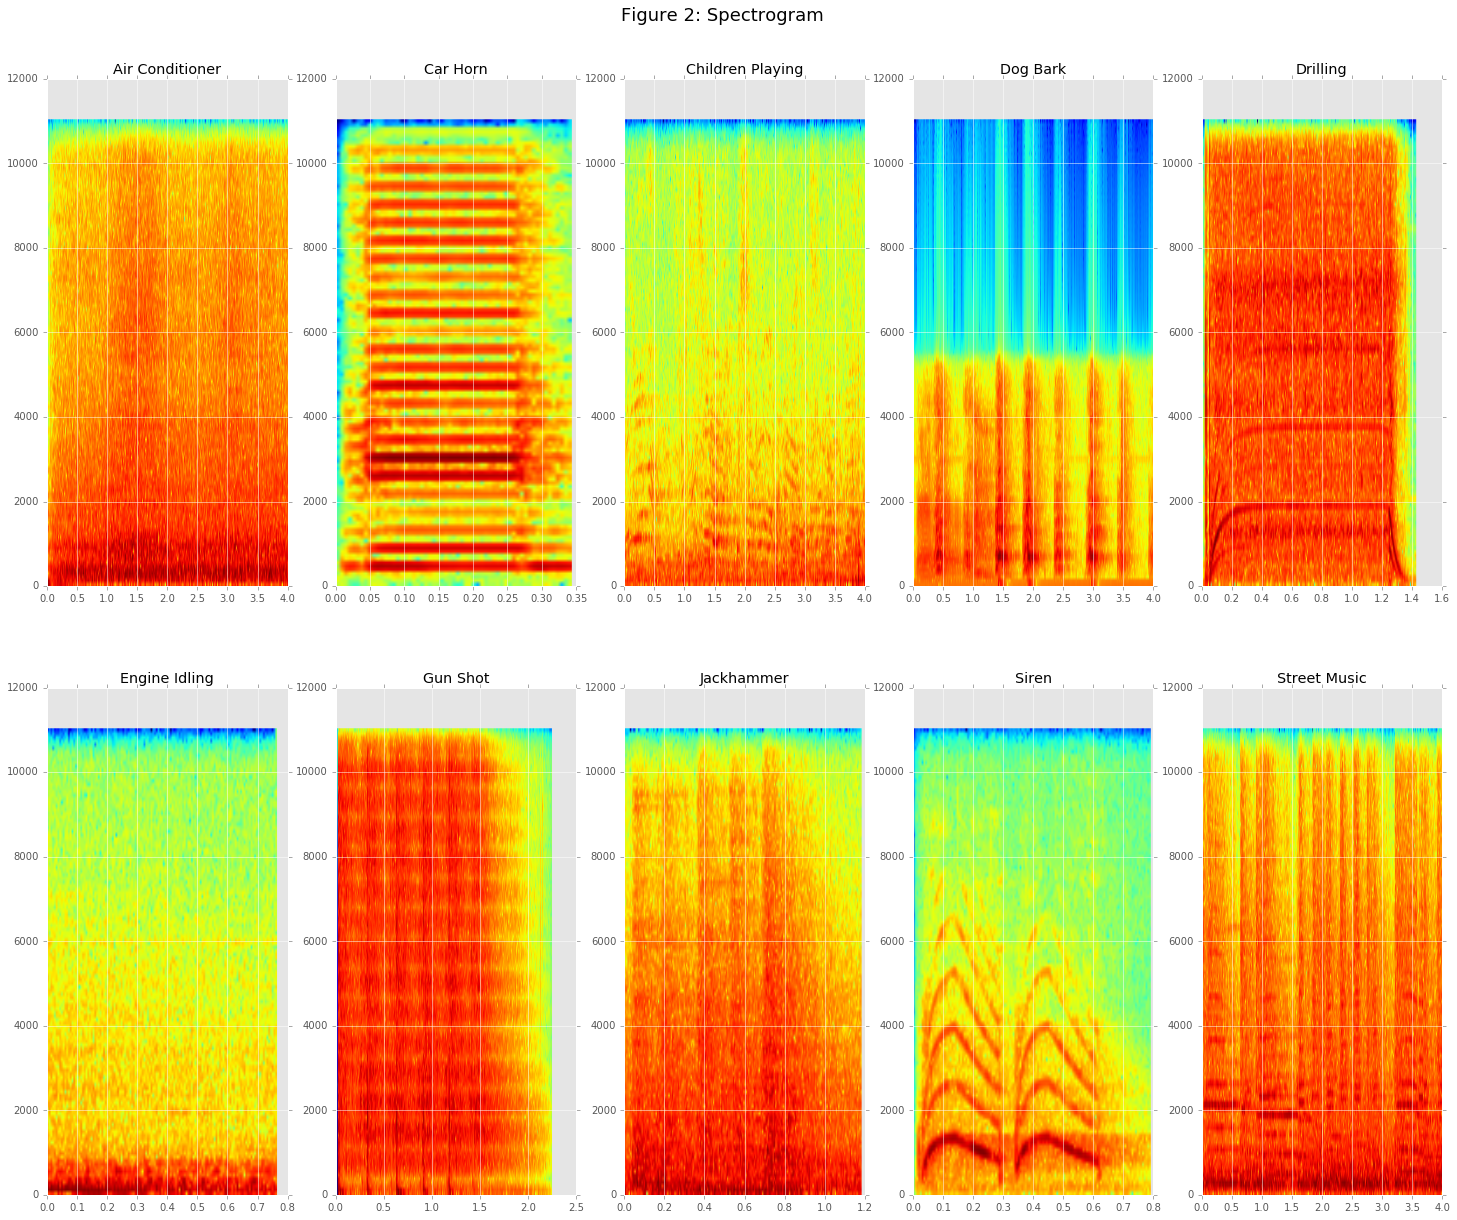

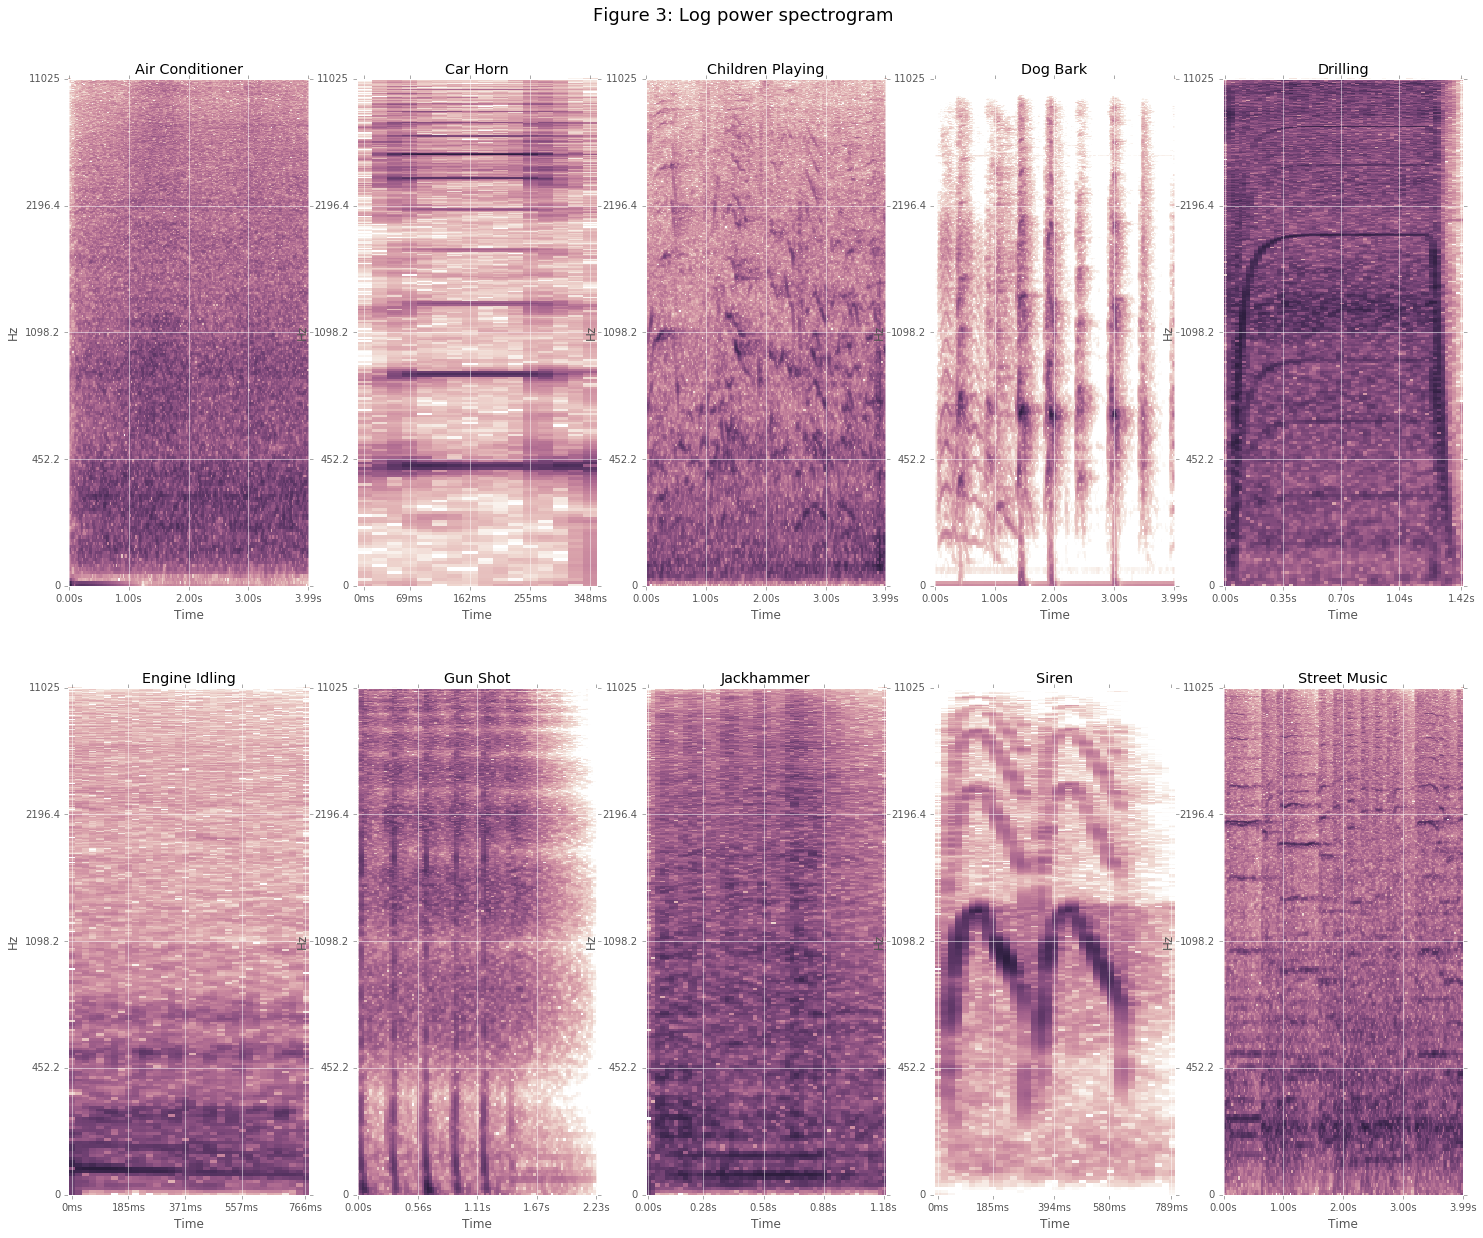

In [16]:
plot_waves(sound_names, raw_sounds)
plot_specgram(sound_names, raw_sounds)
plot_log_power_specgram(sound_names, raw_sounds)

The images above show visualisations of the raw data, but some feature extraction is necessary, which will reduce the tens of thousands of data points in each file (this number varies according to the duration of the clip), into a much smaller set of consistent, potentially pertinent features. That means we'll always have the same features for each clip, regardless of how long or short it is. 

The librosa library comes with several methods (http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf), including:

* Mel-frequency cepstral coefficients (MFCC) - https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
* Chromagram of a short-time Fourier transform - projects bins representing the 12 distinct semitones (or chroma) of the musical octave http://labrosa.ee.columbia.edu/matlab/chroma-ansyn/
* Mel-scaled power spectrogram - uses https://en.wikipedia.org/wiki/Mel_scale to provide greater resolution for the more informative (lower) frequencies 
* Octave-based spectral contrast (http://ieeexplore.ieee.org/document/1035731/)
* Tonnetz - estimates tonal centroids as coordinates in a six-dimensional interval space (https://sites.google.com/site/tonalintervalspace/)

The results of the 5 extractions are then concatenated to give a consistent feature vector of 193 values for every audio clip we process.


In [28]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    print len(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
                ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
                features = np.vstack([features,ext_features])
                labels = np.append(labels, fn.split('fold')[1].split('-')[1])
            except:
                print("Error processing " + fn + " - skipping")
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

Here we see the dimensionality reduction in action, how a clip with 26168 data points is reduced into 193 features. 

In [38]:
sample_filename = "samples/us8k/jackhammer.wav"
mfccs, chroma, mel, contrast, tonnetz = extract_feature(sample_filename)
all_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
print "MFCSS  = ", len(mfccs)
print "Chroma = ", len(chroma)
print "Mel = ", len(mel)
print "Contrast = ", len(contrast)
print "Tonnetz = ", len(tonnetz)

data_points, _ = librosa.load(sample_filename)
print "IN: Initial Data Points =", len(data_points)
print "OUT: Total features =", len(all_features)

26168
MFCSS  =  40
Chroma =  12
Mel =  128
Contrast =  7
Tonnetz =  6
IN: Initial Data Points = 26168
OUT: Total features = 193


The code in the cell below can be run (once) to convert the raw audio files into much smaller numpy arrays. As this process is quite time consuming, we'd prefer to just do it once, and then load the numpy data when we want to do some training. 

In [7]:
# use this to process the audio files into numpy arrays
def save_folds(data_dir):
    for k in range(1,11):
        fold_name = 'fold' + str(k)
        print "\nSaving " + fold_name
        features, labels = parse_audio_files(parent_dir, [fold_name])
        labels = one_hot_encode(labels)
        
        print "Features of", fold_name , " = ", features.shape
        print "Labels of", fold_name , " = ", labels.shape
        
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        np.save(feature_file, features)
        print "Saved " + feature_file
        np.save(labels_file, labels)
        print "Saved " + labels_file
    
# uncomment this to recreate and save the feature vectors
# raw_data_dir = "Where you have saved the UrbanSound8K data set"       
# save_dir = "data/us8k-np-ffn"
# assure_path_exists(save_dir)
# save_folds()


Saving fold1
Features of fold1  =  (873, 193)
Labels of fold1  =  (873, 10)
Saved npdata/fold1_x.npy
Saved npdata/fold1_y.npy

Saving fold2
Features of fold2  =  (888, 193)
Labels of fold2  =  (888, 10)
Saved npdata/fold2_x.npy
Saved npdata/fold2_y.npy

Saving fold3
Features of fold3  =  (925, 193)
Labels of fold3  =  (925, 10)
Saved npdata/fold3_x.npy
Saved npdata/fold3_y.npy

Saving fold4
Features of fold4  =  (990, 193)
Labels of fold4  =  (990, 10)
Saved npdata/fold4_x.npy
Saved npdata/fold4_y.npy

Saving fold5
Features of fold5  =  (936, 193)
Labels of fold5  =  (936, 10)
Saved npdata/fold5_x.npy
Saved npdata/fold5_y.npy

Saving fold6
Features of fold6  =  (823, 193)
Labels of fold6  =  (823, 10)
Saved npdata/fold6_x.npy
Saved npdata/fold6_y.npy

Saving fold7
Features of fold7  =  (838, 193)
Labels of fold7  =  (838, 10)
Saved npdata/fold7_x.npy
Saved npdata/fold7_y.npy

Saving fold8
Features of fold8  =  (806, 193)
Labels of fold8  =  (806, 10)
Saved npdata/fold8_x.npy
Saved npd

Note: As explained in section 4.2 of  https://serv.cusp.nyu.edu/projects/urbansounddataset/salamon_urbansound_acmmm14.pdf, 
the folds have been created by chopping up longer sound files into shorter (4 second) clips.

Hence we can't draw samples randomly across folds, as some audio clips are repetitive (like sirens and air conditioning) and that would risk segments of the same audio clip occuring in both our training and test set.


Now run notebook 2-us8k-ffn-train-evaluate, and you'll be able load the extracted features and train a model.

--------------------------------------------------------------------------------------------------------------------------